# DV2607 Project Notebook
### Authors:
### Oliver Ljung (ollj19@student.bth.se)
### Phoebe Waters (phaa19@student.bth.se)

## Importing modules and dataset

In [324]:
# imports
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Activation, BatchNormalization, LeakyReLU, Reshape, UpSampling2D, Dropout
from keras import Sequential, Model
from keras.datasets import mnist
from keras.utils import to_categorical
import keras.backend as KB

from keras.losses import BinaryCrossentropy, CategoricalCrossentropy, Hinge # Loss Classes
from keras.losses import binary_crossentropy, categorical_crossentropy, hinge # Loss functions

import random

## Defining functions

In [325]:
# Defining functions

def create_classifier():
    # Create a CNN model
    # Add input
    input = Input(shape = (28,28,1))

    model = Sequential(name="mnist_classifier")

    # Add Convolution layers
    model.add(Conv2D(28, (3,3), activation='relu', input_shape=(28,28,1), name="image_input"))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))

    model.add(Flatten())

    # Add predictive layers
    model.add(Dense(56, activation='relu'))
    model.add(Dense(10, activation='softmax', name="classication_output"))
    
    print(model.summary())

    # Get ouput from model
    prediction = model(input)

    # return model
    return Model(input, prediction, name="mnist_classifier")

def create_generator():
    # Create a CNN model
    model = Sequential(name="generator")

    model.add(Dense(7*7*28, activation='relu', input_dim=100, name="noise_input"))
    model.add(Reshape((7,7,28)))

    model.add(UpSampling2D())
    model.add(Conv2D(28, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())

    model.add(UpSampling2D())
    model.add(Conv2D(56, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())
    
    model.add(Conv2D(1, (3,3), activation='relu', padding="same"))
    model.add(Activation('tanh', name="image_output"))

    print(model.summary())

    input = Input(shape = (100))
    
    img = model(input)
    
    # return model
    return Model(input, img, name="generator")

def create_adv_generator():
    # Create a CNN model
    model = Sequential(name="adv_generator")

    # Add same layers as classifier --> feauture extraction
    model.add(Conv2D(28, (3,3), activation='relu', padding="same", input_shape=(28,28,1), name="image_input"))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(56, (3,3), activation='relu', padding="same"))
    model.add(MaxPooling2D((2, 2)))

    # Add some layers that perturbes
    model.add(Conv2D(56, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())
    model.add(Conv2D(56, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(56, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    
    # Add outputlayer
    model.add(Conv2D(1, (3,3), activation='relu', padding="same"))
    model.add(Activation('tanh', name="adv_image_output"))

    print(model.summary())

    input = Input(shape = (28,28,1))
    
    perturbations = model(input)
    
    # return model
    return Model(input, perturbations, name="adv_generator")

def create_discriminator():
    # Create a CNN model
    model = Sequential(name="discriminator")

    # Add Convolution layers
    model.add(Conv2D(28, (3,3), activation='relu', input_shape=(28,28,1), name="image_input"))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))

    model.add(Flatten())

    # Add predictive layers
    model.add(Dense(56, activation='relu'))
    model.add(Dense(1, activation='sigmoid', name="validity_output"))
    
    print(model.summary())

    # Add input
    input = Input(shape = (28,28,1))

    # Get ouput from model
    validity = model(input)

    # return model
    return Model(input, validity, name="discriminator")

## Loading dataset

In [326]:
# load dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X.astype("float32") / 255
test_X = test_X.astype("float32") / 255

train_X = np.expand_dims(train_X, -1)
test_X = np.expand_dims(test_X, -1)

train_y = to_categorical(train_y)
test_y  = to_categorical(test_y)

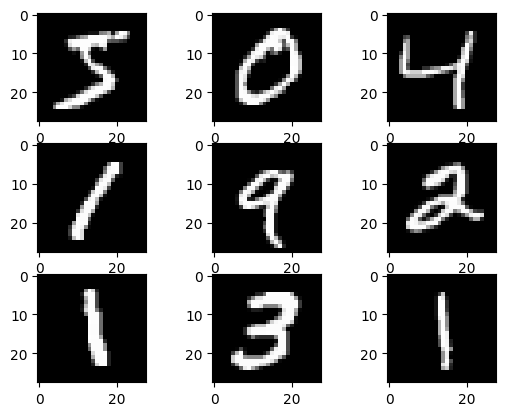

In [327]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

## Training the Classifier; model to attack and later defend

In [328]:
optimizer = tf.optimizers.Adam()

model = create_classifier()
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=["accuracy"])

model.fit(train_X, train_y)
model.save("classifier.h5")

Model: "mnist_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (Conv2D)        (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d_188 (MaxPooli  (None, 13, 13, 28)       0         
 ng2D)                                                           
                                                                 
 conv2d_394 (Conv2D)         (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_189 (MaxPooli  (None, 5, 5, 56)         0         
 ng2D)                                                           
                                                                 
 conv2d_395 (Conv2D)         (None, 3, 3, 56)          28280     
                                                                 
 flatten_93 (Flatten)        (None, 504)          

### Model baseline

In [329]:
model.evaluate(test_X, test_y)

313/313 [==============================] - 3s 10ms/step - loss: 0.0573 - accuracy: 0.9820


[0.05733038857579231, 0.9819999933242798]

## Defining models and input tensors

In [330]:
optimizer = tf.optimizers.Adam(learning_rate=0.01)

input = Input(shape=(28,28,1), name="image")

adv_generator = create_adv_generator()
perturbations = adv_generator(input)

adv_image = tf.add(input, perturbations)
adv_image = tf.clip_by_value(adv_image, 0, 1) # Values in image is [0,1]


# We want the generator and discriminator to be trained in a combined model but as seperate entities
discriminator = create_discriminator()
discriminator.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=["accuracy"])
discriminator.trainable = False
validity = discriminator(adv_image)

# We dont want to train our model to attack
model.trainable = False
prediction = model(adv_image)


# This is a targeted attack
target_prediction = Input(shape= (10,))
target_validity = Input(shape= (1,))
target_hinge_limit = Input(shape= (None, 28,28,1))

advGAN_model = Model(inputs=input, outputs=[perturbations, prediction, validity], name="advGAN-net")

alpha = 1
beta = 1
c = 0

L_adv = CategoricalCrossentropy(from_logits=False)
L_GAN = BinaryCrossentropy(from_logits=False)
L_hinge = Hinge()

losses = {
    "mnist_classifier": L_adv,
    "discriminator": L_GAN,
    "adv_generator": L_hinge,
}

losses_weights = {
    "mnist_classifier": 1,
    "discriminator": alpha,
    "adv_generator": beta,
}

advGAN_model.compile(optimizer=optimizer, loss=losses, loss_weights=losses_weights, metrics=["accuracy"])
advGAN_model.summary()

Model: "adv_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (Conv2D)        (None, 28, 28, 28)        280       
                                                                 
 max_pooling2d_190 (MaxPooli  (None, 14, 14, 28)       0         
 ng2D)                                                           
                                                                 
 conv2d_396 (Conv2D)         (None, 14, 14, 56)        14168     
                                                                 
 max_pooling2d_191 (MaxPooli  (None, 7, 7, 56)         0         
 ng2D)                                                           
                                                                 
 conv2d_397 (Conv2D)         (None, 7, 7, 56)          28280     
                                                                 
 batch_normalization_160 (Ba  (None, 7, 7, 56)       

## AdvGAN Training

In [331]:
BATCH_SIZE = 128 
EPOCHS = 100

y_real = np.ones((BATCH_SIZE, 1))
y_fake = np.zeros((BATCH_SIZE, 1))

# Targeted Attack
target_label = 0
target_prediction = np.zeros(10)
target_prediction[target_label] = 1
target_prediction = np.array([target_prediction]*BATCH_SIZE)

hinge_limit = np.full(shape=(BATCH_SIZE, 28,28,1), fill_value=c)

for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    x_real = np.array(random.choices(train_X, k=BATCH_SIZE))
    
    perturbations = adv_generator.predict(x_real, verbose=0)
    x_fake = x_real + perturbations

    discriminator.train_on_batch(x=x_real, y=y_real)
    discriminator.train_on_batch(x=x_fake, y=y_fake)

    y = {
        "mnist_classifier": target_prediction,
        "discriminator": y_real,
        "adv_generator": hinge_limit
    }

    loss = advGAN_model.train_on_batch(x=x_real, y=y)
    print(f"Total loss = {loss[0]} \n\tLosses: adv_generator = {loss[1]}, mnist_classifier = {loss[2]}, discriminator = {loss[3]}\n\tAccuracy: adv_generator = {loss[4]}, mnist_classifier = {loss[5]}, discriminator = {loss[6]} \n")

# adv_generator.save("mnist_adv_generator.h5")
# discriminator.save("mnist_adv_discriminator.h5")

EPOCH: 0
Total loss = 8.50245475769043 
	Losses: adv_generator = 1.3219126462936401, mnist_classifier = 7.1805419921875, discriminator = 0.0
	Accuracy: adv_generator = 0.6557118892669678, mnist_classifier = 0.109375, discriminator = 1.0 

EPOCH: 1
Total loss = 12.579133987426758 
	Losses: adv_generator = 1.4072647094726562, mnist_classifier = 10.442401885986328, discriminator = 0.7294673323631287
	Accuracy: adv_generator = 0.57763671875, mnist_classifier = 0.09375, discriminator = 0.0 

EPOCH: 2
Total loss = 7.56175422668457 
	Losses: adv_generator = 1.4798409938812256, mnist_classifier = 5.313655853271484, discriminator = 0.7682572603225708
	Accuracy: adv_generator = 0.5159737467765808, mnist_classifier = 0.078125, discriminator = 0.0 

EPOCH: 3
Total loss = 15.3804349899292 
	Losses: adv_generator = 1.4880411624908447, mnist_classifier = 2.281111240386963, discriminator = 11.611282348632812
	Accuracy: adv_generator = 0.5087292790412903, mnist_classifier = 0.359375, discriminator = 0.

4/4 [==============================] - 0s 11ms/step
p = 1
p = 0
p = 2
p = 9
p = 9
p = 8
p = 0
p = 7
p = 0


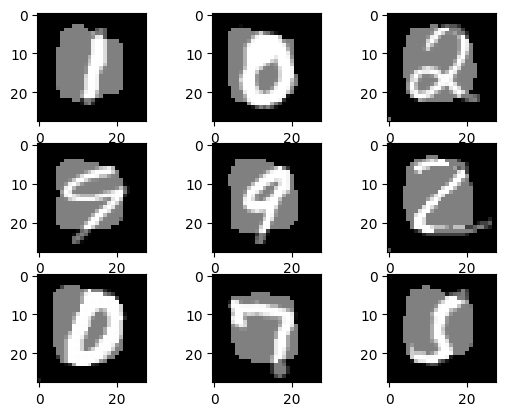

In [332]:
x_real = np.array(random.choices(train_X, k=BATCH_SIZE))

perturbations = adv_generator.predict(x_real)
x_fake = np.add(x_real, perturbations)
x_fake_labels = model.predict(x_fake)

for i in range(9):
    fig = plt.subplot(3, 3, i+1)
    plt.imshow(x_fake[i], cmap=plt.get_cmap('gray'))
    print(f'p = {np.argmax(x_fake_labels[i])}')
plt.show()